In [13]:
import sys
print("Python Version:", sys.version)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
pd.set_option('display.max_rows', 500)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Python Version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [14]:
#Create a color palet to match NYC subway colors
clrs = ['#0039A6', '#FF6319', '#996633', '#6CBE45', '#A7A9AC', '#FCCC0A',
        '#808183', '#EE352E', '#00933C', '#B933AD']

# Metis - Project 1

Anthony Tagliente, Jennifer Sun, Lewis Sears, Rami Subramaniam

# Backstory

>An email from a potential client:
>
>Vinny & Joan -
>
>It was great to meet with you and chat at the event where we recently met and had a nice chat. We’d love to take some next >steps to see if working together is something that would make sense for both parties.
>
>As we mentioned, we are interested in harnessing the power of data and analytics to optimize the effectiveness of our street >team work, which is a significant portion of our fundraising efforts.
>
>WomenTechWomenYes (WTWY) has an annual gala in New York City at the beginning of the fall each year. As we are new and >inclusive organization, we try to do double duty with the gala both to fill our event space with individuals passionate about >increasing the participation of women in technology, and to concurrently build awareness and reach.
>
>To this end we place street teams at entrances to subway stations. The street teams collect email addresses and those who sign >up are sent free tickets to our gala.
>
>Where we’d like to solicit your engagement is to use MTA subway data, which as I’m sure you know is available freely from the >city, to help us optimize the placement of our street teams, such that we can gather the most signatures, ideally from those >who will attend the gala and contribute to our cause.
>
>The ball is in your court now—do you think this is something that would be feasible for your group? From there we can explore >what kind of an engagement would make sense for all of us.
>
>Best,
>
>Karrine and Dahlia
>
>WTWY International

# Data

The data set to be used in this project can be found on [The MTA's website](https://duckduckgo.http://web.mta.info/developers/turnstile.html) and provides cumulative entry and exit data for each turnstile in the NYC subway system.

Our group has chosen the dates August 03, 2019 to September 28, 2019 to reflect the Galas early fall date. While covid has certainly caused changes in transportaion, we feel we can make some assumption that by time a Gala is allowed to happen, subway behavior will likely be close to normal. 

We have created a seperate markdown that is used to collect and clean the MTA Turnstile data, which can be found in the repo as `MTA_Data_Cleaning.ipynb`. For this markdown we will simplky import the pickled final data frame.

In [15]:
# Import cleaned dataframe containing MTA Turnstile Data.
df_turns_no_outlier = pd.read_pickle('Cleaned_Working_Dataframe.pkl')

## Analysis

### Median Traffic per Station for Each Day.

Text(0, 0.5, 'Weekday')

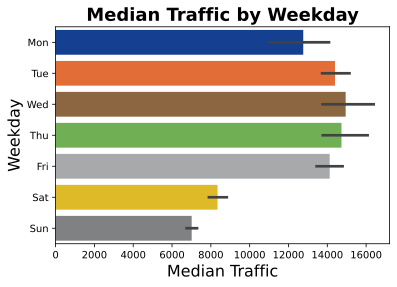

In [16]:
# Set order for days of the week variable.
df_turns_no_outlier['Weekday'] = pd.Categorical(df_turns_no_outlier['Weekday'], categories=
    ['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'],
    ordered=True)

df_days = df_turns_no_outlier.groupby(['DATE','Weekday'],as_index=False).median()

sns.barplot(y ='Weekday',
            x='Total_Traffic_x',
            data=df_days, 
            orient='h', 
            palette=clrs)
plt.title('Median Traffic by Weekday', weight = 'bold', size=18)
plt.xlabel('Median Traffic',size=16)
plt.ylabel('Weekday',size=16)

Looking at the data, the amount of traffic across various weekdays is fairly similar. This is true across most stations. Weekends however are a bit different from weekdays, so we have decided to split our data into two groups. One for analysing trends during weekdays, and one for looking at weekends.

### The Busiest Stations

As one of the stated goals of the organization is to raise awareness for the event as well as their work in general, targeting high traffic stations is a good first step. As you might expect, the more central commuter stations have the most average daily traffic. 

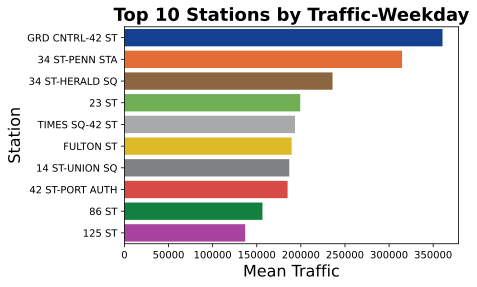

In [17]:
# Create a data table filtered down to Weekday data.
df_filt_weekdays = df_turns_no_outlier[df_turns_no_outlier.Weekday.isin(['Mon','Tue','Wed','Thu','Fri'])]

# Group the table by station to get average daily traffic per station during the workweek.
df_filt_weekdays = df_filt_weekdays.groupby(['STATION'], as_index=False).mean()

# Return the top 10 busiest stations on weekdays.
df_filt_weekdays = df_filt_weekdays.sort_values('Total_Traffic_x', ascending=False).head(10)

# Create bar chart to illustrate point
sns.barplot(x ='Total_Traffic_x',
            y='STATION',
            data=df_filt_weekdays,
            orient='h', 
            palette=clrs)
plt.title('Top 10 Stations by Traffic-Weekday', weight = 'bold', size=18)
plt.xlabel('Mean Traffic',size=16)
plt.ylabel('Station',size=16)
plt.savefig('Top 10.svg')

On the weekends, the top stations largely remain the same, but there is some change which should be taken into account.

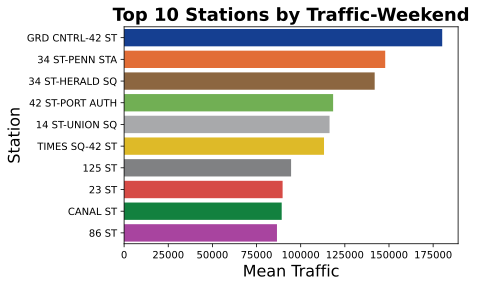

In [18]:
# Create chart of stations with the highest average daily traffic on weekends.
df_filt_weekend = df_turns_no_outlier[df_turns_no_outlier.Weekday.isin(['Sat','Sun'])]
df_filt_weekend = df_filt_weekend.groupby(['STATION'], as_index=False).mean()
df_filt_weekend = df_filt_weekend.sort_values('Total_Traffic_x', ascending=False).head(10)

#Create plot
sns.barplot(x ='Total_Traffic_x',
            y='STATION',
            data=df_filt_weekend, 
            orient='h', 
            palette=clrs)
plt.title('Top 10 Stations by Traffic-Weekend', weight = 'bold', size=18)
plt.xlabel('Mean Traffic',size=16)
plt.ylabel('Station',size=16)
plt.savefig('Top 10.svg')

## Bring in Census Data and Develop a Scoring System

In this section we can import the census data we have collected and develop our scoring system for ranking charts and building our station map. Folium is a python package that allows us to use the Leaflet Javascript library.

The Census Bureau has a very useful and free API that can be found [here](https://www.census.gov/data/developers/data-sets/acs-5year.html). Using this we were able to get demographic information at the tract level based on the location of the various train stations.  This should give us some insight into the people who live near the station, and are likely to use it. 

As the organization is focused on women in tech, we felt that a good place to start was to look at the percentage of the population around the stations that were women, were employed in tech related industries, and had higher income.

This process is easily customizable and an exhaustive list of variables that can be included is available [here](https://api.census.gov/data/2018/acs/acs5/subject/variables.html).

## Adding Census Data to Average Daily Traffic per Station

In [19]:
#Make Map for Weekdays by filtering our weekday column and aggregating at the station level.
df_filt_weekdays = df_turns_no_outlier[df_turns_no_outlier.Weekday.isin(['Mon','Tue','Wed','Thu','Fri'])]
df_filt_weekdays = df_filt_weekdays.groupby(['STATION'], as_index=False).mean()


# bring in Census data that was created with a seperate R script.
cen_dat = pd.read_csv('geocoded_cen_dat.csv')

# Identify the columns from census data that we want to use in our new combined dataframe.
cen_vars=['STATION',
          'LAT',
          'LON',
          'p_f_pop',
          'p_emp_info',
          'p_emp_prof',
          'p_75_100k',
          'p_over_100k']

# Add census Data to Weekday Station Data with a left join on station
df_filt_weekdays_cen=pd.merge(df_filt_weekdays, 
                              cen_dat[cen_vars],  
                              how='left', 
                              left_on=['STATION'], 
                              right_on = ['STATION']
                             )

# Because census data includes the division column, stations become duplicated. We can just remove the duplicates.
df_filt_weekdays_cen =df_filt_weekdays_cen.drop_duplicates(['STATION'])

### Creating a Scoring System

When looking at our census data, it can be difficult to make any judgments without the broader context of other locations. As an example, is 40% female population a high amount, or a low amount? In order to make things more interpretable we can convert the data into a percentile ranking. We can also do this for traffic volumes so all our data can be easily added to a final score.

We have taken the liberty to make some judgments on percieved importance of these factors to the organization, but it should mainly be used to start the conversation. These weights can be adjusted to better match the organizations values, and as mentioned, additional variables can be brought in for specific targeting.

!['weighting factors'](MTA_Visuals/census_weighting.png)

#### Scoring Weekday Data

In [20]:
# Convert Census and Traffic Data to a percentile ranking and multiply by 100. Stations with the highest values 
# for each Variable with have a score of 100 and the lowest will recieve a 0.

df_filt_weekdays_cen['Traffic_Rank'] = df_filt_weekdays_cen['Total_Traffic_x'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_f_pop_Rank'] = df_filt_weekdays_cen['p_f_pop'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_emp_info_Rank'] = df_filt_weekdays_cen['p_emp_info'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_emp_prof_Rank'] = df_filt_weekdays_cen['p_emp_prof'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_75_100k_Rank'] = df_filt_weekdays_cen['p_75_100k'].rank(ascending=True,pct=True)*100
df_filt_weekdays_cen['p_over_100k_Rank'] = df_filt_weekdays_cen['p_over_100k'].rank(ascending=True,pct=True)*100

# Calculate a Recommendation Score using custom weights. To give certain variables more influence on the score, increase their
# weight. Weights should sum to 1.
df_filt_weekdays_cen['Recommending_Score'] = (df_filt_weekdays_cen['Traffic_Rank'] * .50) +\
                                       (df_filt_weekdays_cen['p_f_pop_Rank'] * .2)+ \
                                       (df_filt_weekdays_cen['p_emp_info_Rank'] * .1)+ \
                                       (df_filt_weekdays_cen['p_emp_prof_Rank'] * .1)+ \
                                       (df_filt_weekdays_cen['p_75_100k_Rank'] * .05)+ \
                                       (df_filt_weekdays_cen['p_over_100k_Rank'] * .05)

# Create a dataframe that is sorted on traffic and keeps the top 100 stations.
df_filt_weekdays_cen_traf = df_filt_weekdays_cen.sort_values('Total_Traffic_x', ascending=False).head(100).reset_index(drop=True)

# Create a dataframe that is sorted on our custom recommendation score.
df_filt_weekdays_cen_score =df_filt_weekdays_cen.sort_values('Recommending_Score', ascending=False).head(10).reset_index(drop=True)



#### Scoring Weekend Data

In [21]:
#Make Map for Weekends using process above.
df_filt_weekends = df_turns_no_outlier[df_turns_no_outlier.Weekday.isin(['Sat','Sun'])]
df_filt_weekends = df_filt_weekends.groupby(['STATION'], as_index=False).mean()

# Add census Data to Weekend Station Data with a left join on station
df_filt_weekends_cen=pd.merge(df_filt_weekends, 
                              cen_dat[cen_vars],  
                              how='left', 
                              left_on=['STATION'], 
                              right_on = ['STATION']
                             )

# Because census data includes division stations become duplicated. We can just remove the duplicates.
df_filt_weekends_cen =df_filt_weekends_cen.drop_duplicates(['STATION'])
df_filt_weekends_cen.sort_values('Total_Traffic_x', ascending=False).head(100)

# Convert Census and Traffic Data to a percentile ranking and multiply by 100. Stations with the highest values for each
# Variable with have a score of 100 and the lowest will recieve a 0. This will help make the variables easier to combine
# into a score in the future.
df_filt_weekends_cen['Traffic_Rank'] = df_filt_weekends_cen['Total_Traffic_x'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_f_pop_Rank'] = df_filt_weekends_cen['p_f_pop'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_emp_info_Rank'] = df_filt_weekends_cen['p_emp_info'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_emp_prof_Rank'] = df_filt_weekends_cen['p_emp_prof'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_75_100k_Rank'] = df_filt_weekends_cen['p_75_100k'].rank(ascending=True,pct=True)*100
df_filt_weekends_cen['p_over_100k_Rank'] = df_filt_weekends_cen['p_over_100k'].rank(ascending=True,pct=True)*100

# Calculate a Recommendation Score
df_filt_weekends_cen['Recommending_Score'] = (df_filt_weekends_cen['Traffic_Rank'] * .50) +\
                                       (df_filt_weekends_cen['p_f_pop_Rank'] * .2)+ \
                                       (df_filt_weekends_cen['p_emp_info_Rank'] * .1)+ \
                                       (df_filt_weekends_cen['p_emp_prof_Rank'] * .1)+ \
                                       (df_filt_weekends_cen['p_75_100k_Rank'] * .05)+ \
                                       (df_filt_weekends_cen['p_over_100k_Rank'] * .05)

df_filt_weekends_cen_traf = df_filt_weekends_cen.sort_values('Total_Traffic_x', ascending=False).head(100).reset_index(drop=True)
df_filt_weekends_cen_score =df_filt_weekends_cen.sort_values('Recommending_Score', ascending=False).head(10).reset_index(drop=True)



## Top 10 Stations Using our Score

Now we can look at the top scoring stations, similar to what we have seen before using only traffic. We can see that the top recommendations have now changed quite a bit. While we wanted to keep traffic in the score calculation so as not to waste resources on empty stations, our current system should help with a balanced approach.

We feel that the top 3 stations from the list would be a good place to focus attention, being sure to adjust when working on weekdays or weekends.

It is also important to mention that Fulton and 23rd St stations have performed well in both raw traffic numbers as well as our scoring system, which could indicate a very good match to the organizations goals.

### Weekdays

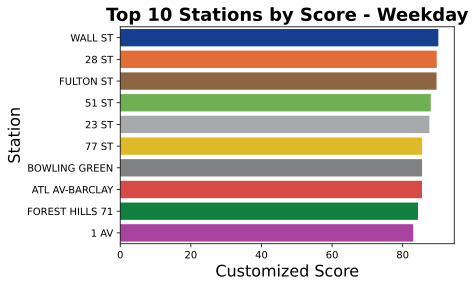

In [22]:
#Create a top 10 plot of stations based on our scoring system.

sns.barplot(x ='Recommending_Score',y='STATION',data=df_filt_weekdays_cen_score, orient='h', palette=clrs)
plt.title('Top 10 Stations by Score - Weekday', weight = 'bold', size=18)
plt.xlabel('Customized Score',size=16)
plt.ylabel('Station',size=16)
plt.savefig('Top 10.svg')

### Weekends

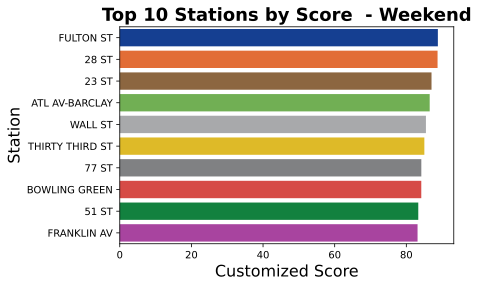

In [23]:
#Create a top 10 plot of stations based on our scoring system.

sns.barplot(x ='Recommending_Score',y='STATION',data=df_filt_weekends_cen_score, orient='h', palette=clrs)
plt.title('Top 10 Stations by Score  - Weekend', weight = 'bold', size=18)
plt.xlabel('Customized Score',size=16)
plt.ylabel('Station',size=16)
plt.savefig('Top 10.svg')

### Mapping the Data

We can now build a map that will highlight the top 10 stations by traffic, the top 10 stations by our scoring system. The size of the circles on the map will represent their average daily traffic, divided by 300 in order to scale them down so they will fit on the map better.

This could help to better contextualize the recommendations and may be beneficial when considering travel for the street teams.

Green circles will show the busiest stations, while yellow circles will show the stations which score highest in our custom scoring system. The additional orange circles simply highlight other high traffic stations that are not recommended, but shown for context.

In [24]:
# Create a list of station coordinates to be passed to the map.
stations = df_filt_weekdays_cen_traf[['LAT','LON']]
stations_list=stations.values.tolist()

#Define coordinates of map center
nyc_coords = [40.7528, -73.9560]

#Create the map object
my_map = folium.Map(location = nyc_coords, zoom_start = 12)

# Iterate through our ranked stations, showing the top 10 as larger green circles and the other stations as 
# smaller yellow circles. The radius of the circles will be determined by their total traffic numbers 300
for point in range(0, len(stations_list)):
    if point <=10:
         folium.Circle(stations_list[point], 
                       popup=df_filt_weekdays_cen_traf.STATION[point],
                       fill=True,
                       radius=df_filt_weekdays_cen_traf.Total_Traffic_x[point]/300,
                       color='#00933C').add_to(my_map)
    else:
        folium.Circle(stations_list[point], 
                      popup=df_filt_weekdays_cen_traf.STATION[point],
                      fill=True,
                      radius=df_filt_weekdays_cen_traf.Total_Traffic_x[point]/300,
                      color='#FF6319').add_to(my_map)

# Add top 10 stations by score in orange circles using same method as above.
stations_score = df_filt_weekdays_cen_score[['LAT','LON']]
stations_list_score=stations_score.values.tolist()

for point in range(0,10):
    folium.Circle(stations_list_score[point], 
                  popup=df_filt_weekdays_cen_score.STATION[point],
                  fill=True,
                  radius=df_filt_weekdays_cen_score.Total_Traffic_x[point]/300,
                  color='#FCCC0A').add_to(my_map)   

# Dark map tiles
folium.TileLayer('cartodbdark_matter').add_to(my_map)

# light map tiles
folium.TileLayer('cartodbpositron').add_to(my_map)

# add layer control for easier swapping light and dark, not sure which we will use.
folium.LayerControl().add_to(my_map)    
my_map   

# Weekend Map

Going through the same process but filtering to our weekend set. In this case, as the traffic levels are lower on weekends, we can divide the traffic by 200 for scaling purposes.

Green circles will show the busiest stations, while yellow circles will show the stations which score highest in our custom scoring system. The additional orange circles simply highlight other high traffic stations that are not recommended, but shown for context.

In [25]:
# Create a list of station coordinates to be passed to the map.
stations = df_filt_weekends_cen_traf[['LAT','LON']]
stations_list=stations.values.tolist()
#Define coordinates of map center
nyc_coords = [40.7528, -73.9560]

#Create the map
my_map = folium.Map(location = nyc_coords, zoom_start = 12)

for point in range(0, len(stations_list)):
    if point <=10:
         folium.Circle(stations_list[point], 
                       popup=df_filt_weekends_cen_traf.STATION[point],
                       fill=True,
                       radius=df_filt_weekends_cen_traf.Total_Traffic_x[point]/200,
                       color='#00933C').add_to(my_map)
    else:
        folium.Circle(stations_list[point], popup=df_filt_weekends_cen_traf.STATION[point],fill=True,radius=df_filt_weekends_cen_traf.Total_Traffic_x[point]/200,color='#FF6319').add_to(my_map)


# Add top 10 stations by score in orange circles
stations_score = df_filt_weekends_cen_score[['LAT','LON']]
stations_list_score=stations_score.values.tolist()


for point in range(0,10):
    folium.Circle(stations_list_score[point], popup=df_filt_weekends_cen_score.STATION[point],fill=True,radius=df_filt_weekends_cen_score.Total_Traffic_x[point]/200,color='#FCCC0A').add_to(my_map)

# Dark map tiles
folium.TileLayer('cartodbdark_matter').add_to(my_map)

# light map tiles
folium.TileLayer('cartodbpositron').add_to(my_map)
# add layer control for easier swapping light and dark, not sure which we will use.
folium.LayerControl().add_to(my_map)
my_map  

# Daily Trends

We now introduce a new column that groups all traffic by the time of day. Splitting this data into weekend and weekday data frames, we can see clear patterns in daily commuting behavior. 

In [50]:
%run Daily_Trends_Dataframe.ipynb

Python Version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [52]:
#Group the data into Weekday vs. Weekend 
df_buckets_grouped = df_turns.groupby(['STATION','Day_Bucket','Day_Type'])['Total_Traffic'].mean().reset_index()
df_buckets_weekday = df_buckets_grouped[df_buckets_grouped['Day_Type'] == 'Weekday']
df_buckets_weekend = df_buckets_grouped[df_buckets_grouped['Day_Type'] == 'Weekend']

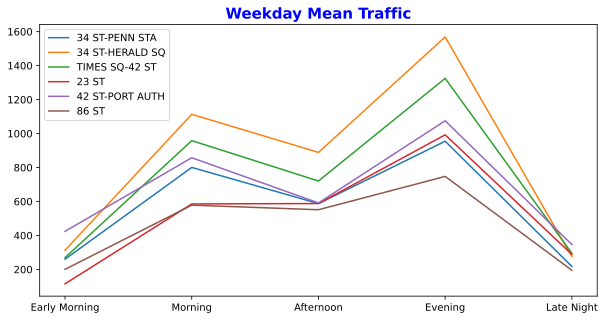

In [47]:
#Busy Stations during Weekdays

plt.figure(figsize=(10,5))
for station in ['34 ST-PENN STA', '34 ST-HERALD SQ', 'TIMES SQ-42 ST', '23 ST', '42 ST-PORT AUTH', '86 ST']:
    plt.plot(df_buckets_weekday[df_buckets_weekday['STATION'] == station]['Day_Bucket'],df_buckets_weekday[df_buckets_weekday['STATION'] == station]['Total_Traffic'])

plt.title('Weekday Mean Traffic',fontsize = 15,weight='bold',color='Blue')
plt.legend(['34 ST-PENN STA', '34 ST-HERALD SQ', 'TIMES SQ-42 ST', '23 ST', '42 ST-PORT AUTH', '86 ST']);
plt.savefig('Weekday_Traffic.png')

This chart isn't very suprising. Traffic is busiest in stations during the rush hour intervals 8:00am to 12:00pm and 4:00pm to 8:00pm. We should focus our street efforts during those two time periods on weekdays. 

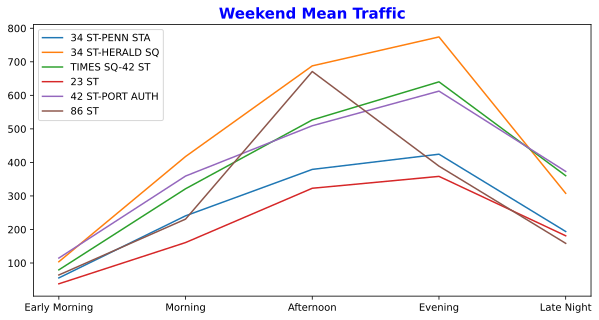

In [48]:
#Busy Stations During Weekends

plt.figure(figsize=(10,5))
for station in ['34 ST-PENN STA', '34 ST-HERALD SQ', 'TIMES SQ-42 ST', '23 ST', '42 ST-PORT AUTH', '86 ST']:
    plt.plot(df_buckets_weekend[df_buckets_weekend['STATION'] == station]['Day_Bucket'],df_buckets_weekend[df_buckets_weekend['STATION'] == station]['Total_Traffic'])

plt.title('Weekend Mean Traffic',fontsize = 15,weight='bold',color='Blue')
plt.legend(['34 ST-PENN STA', '34 ST-HERALD SQ', 'TIMES SQ-42 ST', '23 ST', '42 ST-PORT AUTH', '86 ST']);
plt.savefig('Weekend_Traffic.png')

Although overall traffic is down on the weekend, there is still a time period between 12:00pm and 8:00pm where we can be significantly more effective. 